In [5]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *

In [6]:
scan_name ="Co_XAS_004"

DIR_json = "/sf/alvra/data/p18836/raw/scan_info/"
DIR = "/sf/alvra/data/p18836/raw/scan_data/" + scan_name + "/"             #use this for a scan

#######################################################################

!ls -lah -rt $DIR | grep h5
!hostname

-rw-r--r--. 1 root p18836 1002M Dec  3 08:59 run_000372.JF04T01V01.h5
-rw-r--r--. 1 root p18836 1002M Dec  3 09:00 run_000373.JF04T01V01.h5
-rw-r--r--. 1 root p18836 1002M Dec  3 09:00 run_000374.JF04T01V01.h5
-rw-r--r--. 1 root p18836 1002M Dec  3 09:00 run_000375.JF04T01V01.h5
-rw-r--r--. 1 root p18836 1002M Dec  3 09:00 run_000376.JF04T01V01.h5
-rw-r--r--. 1 root p18836   35M Dec  3 09:00 run_000372.BSDATA.h5
-rw-r--r--. 1 root p18836   90M Dec  3 09:00 run_000372.BSREAD.h5
-rw-r--r--. 1 root p18836 1002M Dec  3 09:01 run_000377.JF04T01V01.h5
-rw-r--r--. 1 root p18836   90M Dec  3 09:01 run_000373.BSREAD.h5
-rw-r--r--. 1 root p18836   35M Dec  3 09:01 run_000373.BSDATA.h5
-rw-r--r--. 1 root p18836 1002M Dec  3 09:01 run_000378.JF04T01V01.h5
-rw-r--r--. 1 root p18836   34M Dec  3 09:01 run_000374.BSDATA.h5
-rw-r--r--. 1 root p18836   90M Dec  3 09:01 run_000374.BSREAD.h5
-rw-r--r--. 1 root p18836 1002M Dec  3 09:01 run_000379.JF04T01V01.h5
-rw-r--r--. 1 root p18836   34M Dec  3 09:01

ra-c-002.psi.ch


# Load one step and check I0 filtering

In [109]:
f ="run_000405.*.h5"
fn = DIR + f

channel_list = [channel_PIPS_trans, channel_Izero122, channel_energy, 'JF04T01V01']

results = load_data_compact(channel_list, fn)

Energy_shot   = results[channel_energy]
IzeroFEL_shot = results[channel_Izero122]
DataFluoPIPS_shot = - results[channel_PIPS_trans]
DataFluoJFimage_shot = results ['JF04T01V01']

Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF04T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18836/raw/JF_pedestals/run_000555.JF04T01V01.res.h5
jungfrau file: 09:07 03.12.2020
pedestal file: 17:27 03.12.2020
    mtime difference: -8:20:50.756340

--------------------------------------------------------------------------------

JF04T01V01                        1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet           1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET          1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 5 / 5 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


## check for PIPS diode

Energy = 7723.00989329719 eV
Median value Izero (all) = 0.23898106813430786
Median value fluo (all) = 0.018775115565009964
correlation = 0.976126217435022


<IPython.core.display.Javascript object>


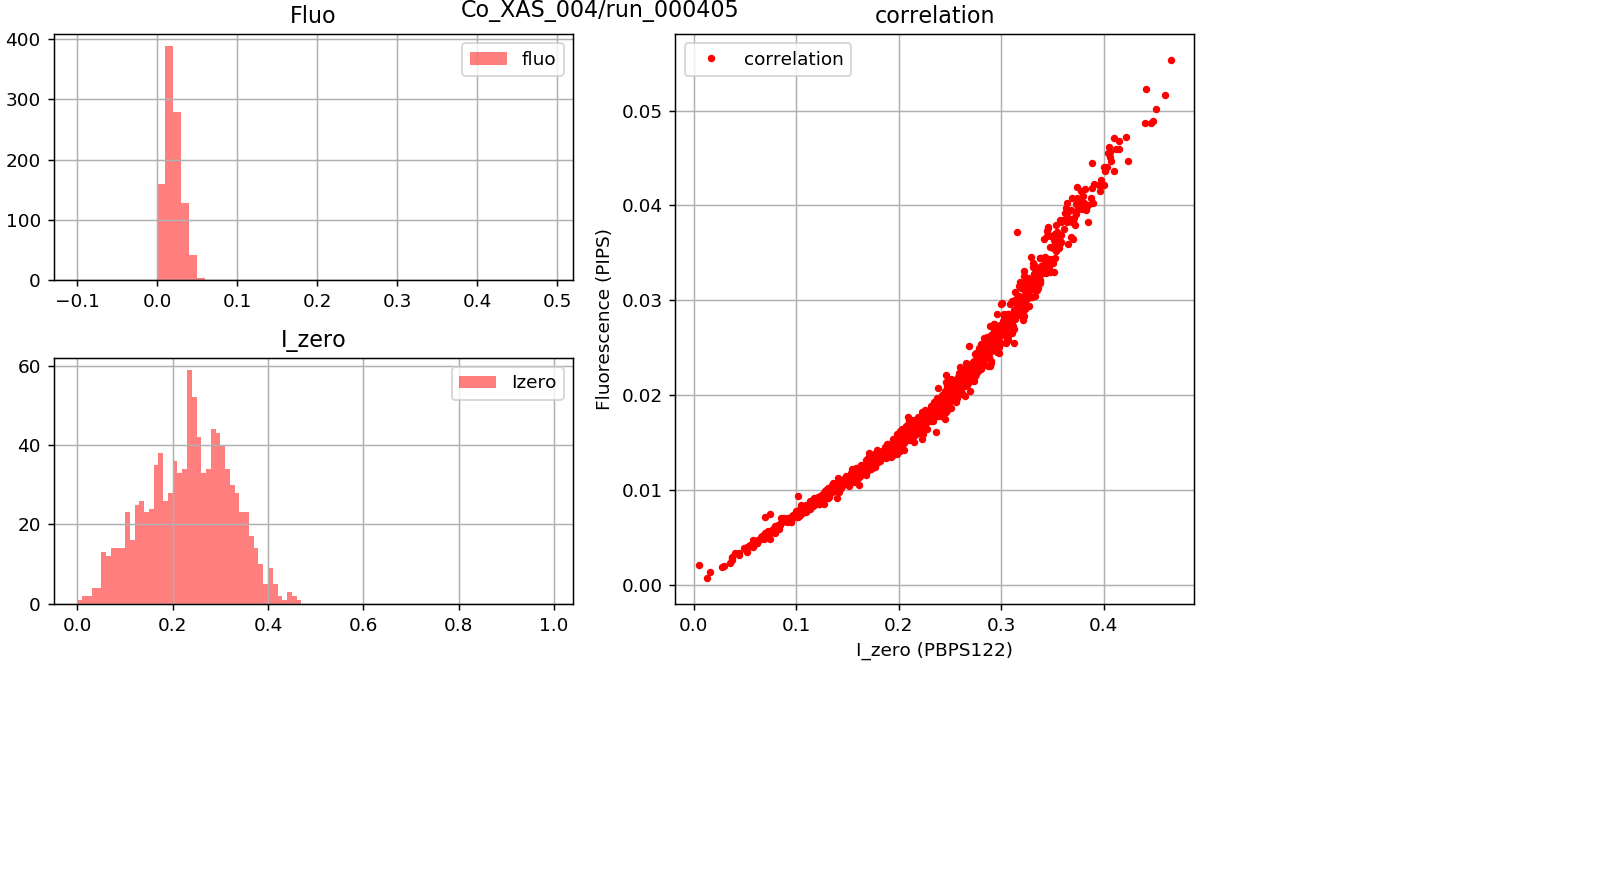

In [127]:
from scipy.stats.stats import pearsonr

IzeroFEL_shot_raw = IzeroFEL_shot.copy()
#DataTrans_shot_raw = DataTrans_shot.copy()
DataFluoPIPS_shot_raw = DataFluoPIPS_shot.copy()

print ("Energy = {} eV".format(np.median(Energy_shot)))
print ("Median value Izero (all) = {}".format(np.median(IzeroFEL_shot_raw)))
print ("Median value fluo (all) = {}".format(np.median(DataFluoPIPS_shot)))
print ("correlation = {}".format(pearsonr(IzeroFEL_shot,DataFluoPIPS_shot)[0]))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(scan_name +"/"+ f.split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluoPIPS_shot, bins =np.arange(-0.1,0.5,0.01), facecolor='red', label="fluo", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_shot, bins =np.arange(0,1,0.01), facecolor='red', label='Izero', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_shot, DataFluoPIPS_shot, color = 'red',  linestyle='None', label='correlation',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (PIPS)")

plt.show()

## check for JF (in TFY)

Energy = 7723.00989329719 eV
Median value Izero (all) = 0.23898106813430786
Median value fluo (all) = 17.59609031677246
correlation = 0.9238222344993885


<IPython.core.display.Javascript object>


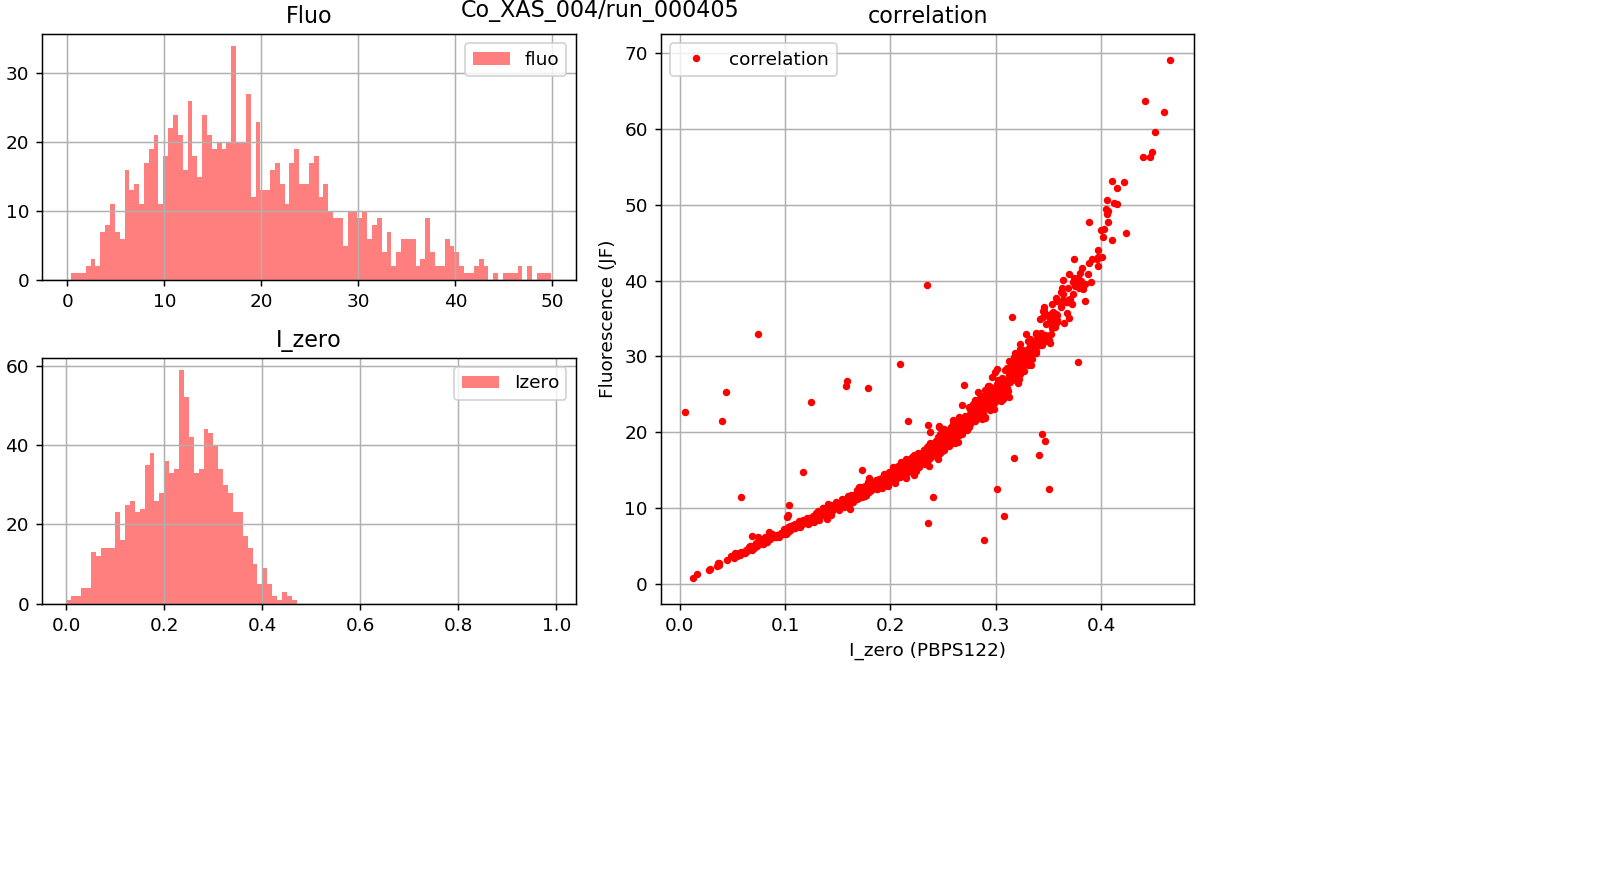

In [139]:
threshold_low = 5
threshold_high = 10

pid_roll = 31

#nframes = DataFluo_shot.shape[0]
#for j in range(nframes):
#    #image = DataFluo_shot[j,:]
#    image_thr = DataFluo_shot[j,:].copy()
#    image_thr[image < threshold_low] = 0
#    #image_thr[image > threshold_high] = 0
#    DataFluo_shot[j,:] = image_thr.copy()

IzeroFEL_shot_raw = IzeroFEL_shot.copy()
#DataTrans_shot_raw = DataTrans_shot.copy()
DataFluoJF_shot = np.roll(DataFluoJFimage_shot.mean(axis = 1).mean(axis = 1), pid_roll, axis = 0)
DataFluoJF_shot_raw = DataFluo_shot.copy()

print ("Energy = {} eV".format(np.median(Energy_shot)))
print ("Median value Izero (all) = {}".format(np.median(IzeroFEL_shot_raw)))
print ("Median value fluo (all) = {}".format(np.median(DataFluoJF_shot_raw)))
print ("correlation = {}".format(pearsonr(IzeroFEL_shot,DataFluoJF_shot)[0]))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(scan_name +"/"+ f.split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluoJF_shot, bins =np.arange(-0.1,50,0.5), facecolor='red', label="fluo", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_shot, bins =np.arange(0,1,0.01), facecolor='red', label='Izero', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_shot, DataFluoJF_shot, color = 'red',  linestyle='None', label='correlation',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (JF)")

plt.show()

In [124]:
from scipy.stats.stats import pearsonr

DataFluoJF_shot_rot = np.copy(DataFluoJF_shot)
corr = []

for i in range (50):
    DataFluoJF_shot_rot = np.roll(DataFluoJF_shot, i, axis = 0)
    corr.append(pearsonr(IzeroFEL_shot,DataFluoJF_shot_rot)[0])
corr = np.asarray(corr)
print (np.argmax(corr))

31


<IPython.core.display.Javascript object>


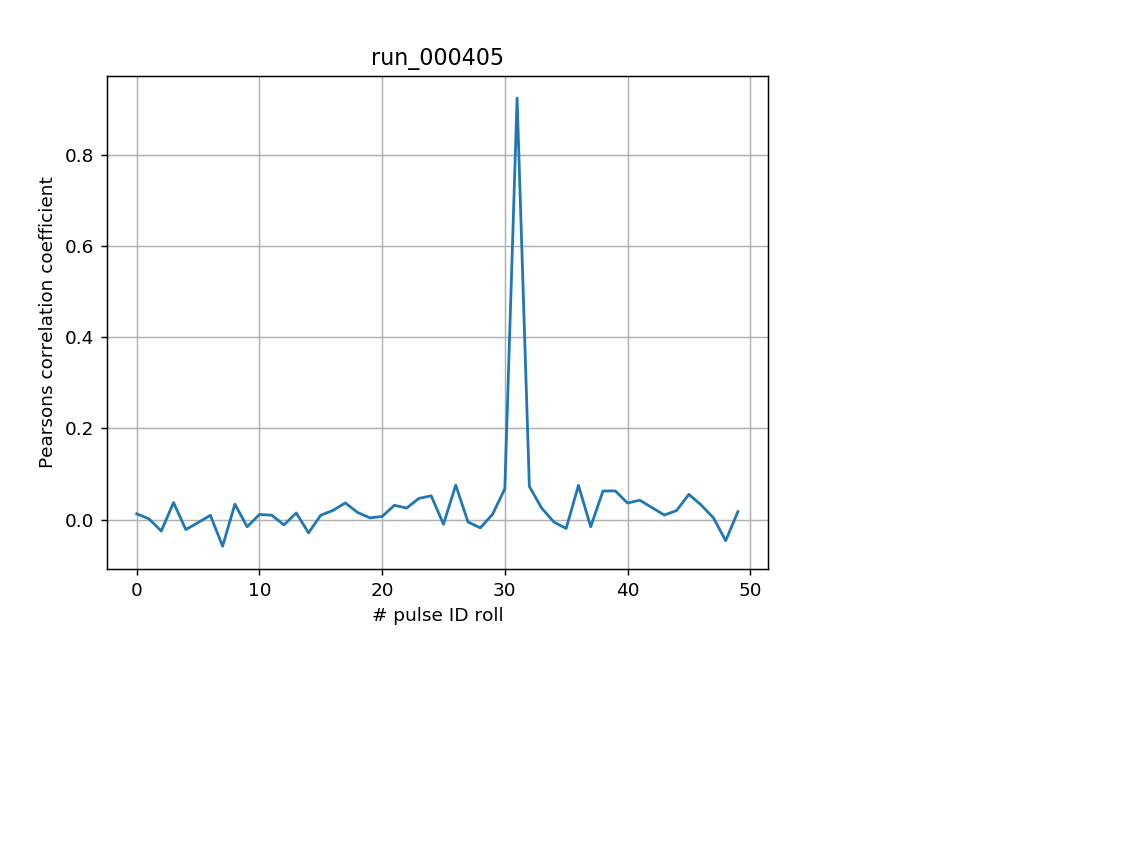

In [133]:
plt.figure()
plt.title(f.split('.')[0])
plt.plot(corr)
plt.ylabel('Pearsons correlation coefficient')
plt.xlabel('# pulse ID roll')
plt.grid()
plt.show()

# Load mono scan

In [94]:
channel_energy

'SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS'

In [91]:
fc = FileChooser('/sf/alvra/data/p18836/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18836/raw/scan_info', filename='', show_hidden='False')

### First, without any filtering of the data, check data distributions with quantiles 

In [ ]:
quantiles = [0.5, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]

channel_list = [channel_PIPS_trans, channel_Izero122, channel_energy]

######################################################
from sfdata import SFScanInfo

json_file = fc.selected
print (json_file)

scan = SFScanInfo(fc.selected)



with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo = []
Energy_eV = []

for i in range(0,numFiles):             
    fn = str(data['scan_files'][i][1])    
    exists = os.path.isfile(fn)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][1])))
        
        results = load_data_compact(channel_list, fn)

        #(DataTrans_shot, DataFluo_shot, IzeroFEL_shot, Laser, Energy_shot, PulseIDs) = load_FEL_scans(fn, channel_energy)
        
        Energy_shot   = results[channel_energy]
        IzeroFEL_shot = results[channel_Izero122]
        DataFluo_shot = -results[channel_PIPS_trans]
        print ("Loaded {} shots".format(len(DataFluo_shot)))
    
        DataFluo_shot_norm = DataFluo_shot / IzeroFEL_shot
        
        df_fluo = pd.DataFrame(DataFluo_shot_norm)
              
        DataFluo.append(np.nanquantile(df_fluo, quantiles))        
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(Energy_shot))
    
DataFluo = np.asarray(DataFluo)
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")

In [71]:
quantiles = [0.5, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]

channel_list = [channel_PIPS_trans, channel_Izero122, channel_energy]

######################################################

json_file = fc.selected
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo = []
Energy_eV = []

for i in range(0,numFiles):             
    fn = str(data['scan_files'][i][1])    
    exists = os.path.isfile(fn)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][1])))
        
        results = load_data_compact(channel_list, fn)

        #(DataTrans_shot, DataFluo_shot, IzeroFEL_shot, Laser, Energy_shot, PulseIDs) = load_FEL_scans(fn, channel_energy)
        
        Energy_shot   = results[channel_energy]
        IzeroFEL_shot = results[channel_Izero122]
        DataFluo_shot = -results[channel_PIPS_trans]
        print ("Loaded {} shots".format(len(DataFluo_shot)))
    
        DataFluo_shot_norm = DataFluo_shot / IzeroFEL_shot
        
        df_fluo = pd.DataFrame(DataFluo_shot_norm)
              
        DataFluo.append(np.nanquantile(df_fluo, quantiles))        
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(Energy_shot))
    
DataFluo = np.asarray(DataFluo)
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")

step 61 of 61 : Processing /sf/alvra/data/p18836/raw/scan_data/Co_XAS_004/run_000432.BSDATA.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET          1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Loaded 1001 shots
Job done!


<IPython.core.display.Javascript object>


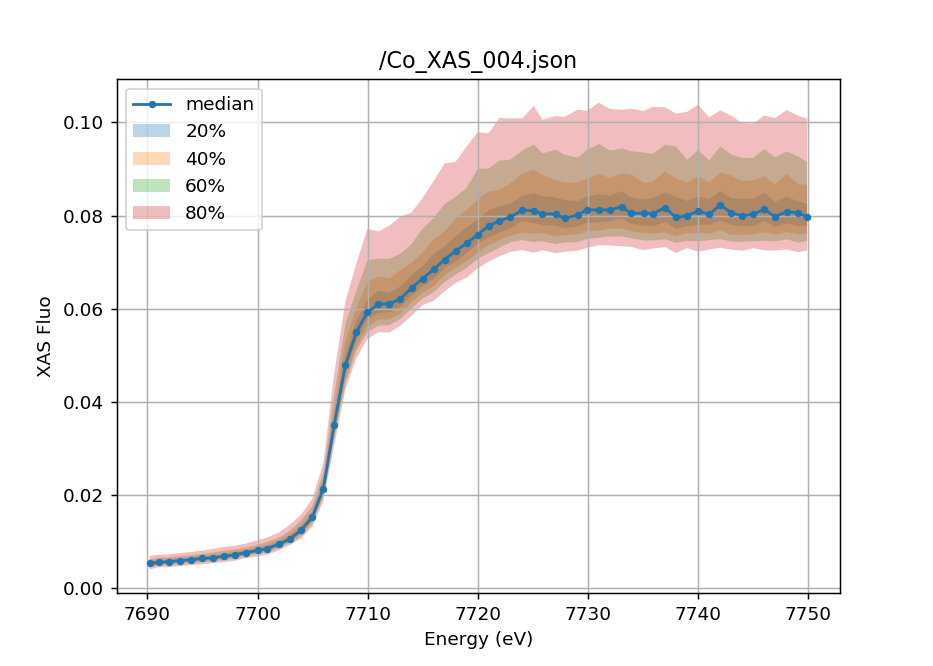

In [72]:
plt.figure(figsize = (7,5))

plt.plot(Energy_eV, DataFluo[:,0],label='median',marker='.' )
plt.fill_between(Energy_eV,np.array(DataFluo[:,4]),np.array(DataFluo[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo[:,3]),np.array(DataFluo[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo[:,2]),np.array(DataFluo[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo[:,1]),np.array(DataFluo[:,8]), label='80%', alpha = 0.3)
plt.grid()

plt.legend(loc="best")
plt.ylabel("XAS Fluo")
plt.xlabel("Energy (eV)")
plt.title(json_file.split('scan_info')[1], fontsize=12)

plt.show()

### Now choose thresholds and quantile

In [74]:
min_I0 = 0.01
min_fluo = 0
quantile_corr = 0.5

channel_list = [channel_PIPS_trans, channel_Izero122, channel_energy]

########################################################################
json_file = fc.selected
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo = []
Energy_eV = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][1])    
    exists = os.path.isfile(filename)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][1])))
        
        results = load_data_compact(channel_list, filename)
        
        #(DataTrans_shot, DataFluo_shot, IzeroFEL_shot, Laser, Energy_shot, PulseIDs) = load_FEL_scans(filename, channel_energy)
        
        Energy_shot   = results[channel_energy]
        IzeroFEL_shot = results[channel_Izero122]
        DataFluo_shot = - results[channel_PIPS_trans]
        
        print ("Loaded {} shots".format(len(DataFluo_shot)))
        
        threshold_FEL = IzeroFEL_shot > min_I0
        threshold_fluo = DataFluo_shot > min_fluo
        thresholds_filter = threshold_FEL & threshold_fluo
        DataFluo_shot = DataFluo_shot[thresholds_filter]
        IzeroFEL_shot = IzeroFEL_shot[thresholds_filter]
        
        print ("survived {} shots".format(len(DataFluo_shot)))
        
        DataFluo_shot_norm = DataFluo_shot / IzeroFEL_shot
        
        med = np.median(DataFluo_shot_norm)
        qnt_low = np.nanquantile(DataFluo_shot_norm, 0.5 - quantile_corr/2)
        qnt_high = np.nanquantile(DataFluo_shot_norm, 0.5 + quantile_corr/2)
        condition_corr_low = DataFluo_shot_norm > qnt_low
        condition_corr_high = DataFluo_shot_norm < qnt_high
        correlation_filter = condition_corr_low & condition_corr_high 
        DataFluo_shot_norm = DataFluo_shot_norm[correlation_filter]
        
        print ("survived {} shots".format(len(DataFluo_shot_norm)))
        
        df_fluo = pd.DataFrame(DataFluo_shot_norm)
        DataFluo.append(np.nanquantile(df_fluo, [0.5, 0, 1]))
        
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(Energy_shot))
    
DataFluo = np.asarray(DataFluo)                  
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")

step 61 of 61 : Processing /sf/alvra/data/p18836/raw/scan_data/Co_XAS_004/run_000432.BSDATA.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET          1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Loaded 1001 shots
survived 993 shots
survived 495 shots
Job done!


<IPython.core.display.Javascript object>


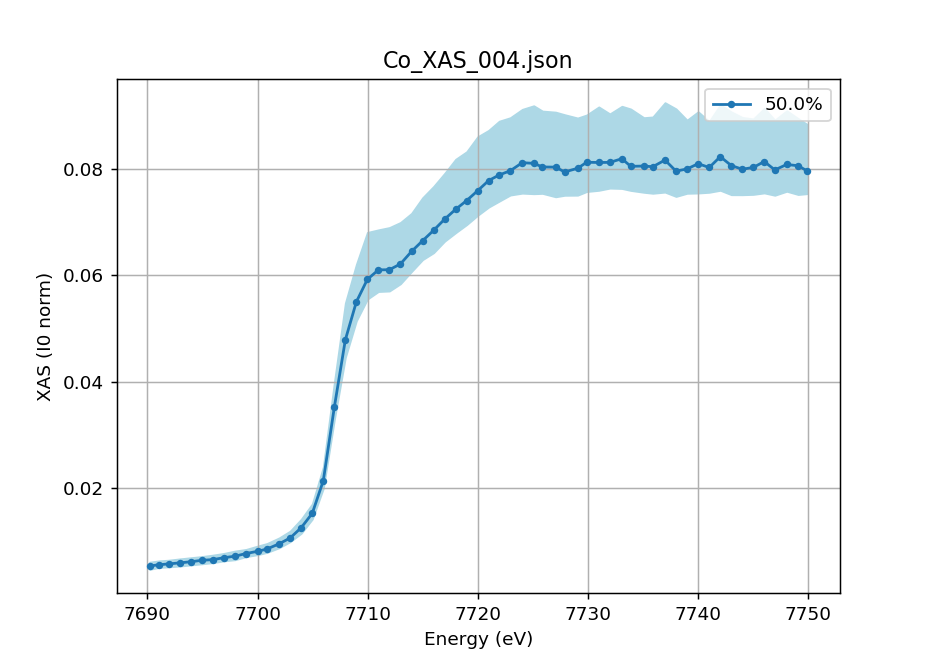

In [77]:
plt.figure(figsize = (7,5))

XAS = DataFluo[:,0]
err_low = DataFluo[:,1]
err_high = DataFluo[:,2]

plt.plot(Energy_eV, XAS, label='{}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Energy_eV, err_low, err_high, color='lightblue')
plt.xlabel("Energy (eV)")
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")
plt.title(fc.selected_filename, fontsize=12)
plt.grid()

plt.show()